In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')


IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 5
FILE_PATH = "./DR_Dataset/resized_train/resized_train"

In [2]:
data = pd.read_csv("./DR_Dataset/trainLabels.csv")
data.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [3]:
images_name = data['image']
labels = data['level']

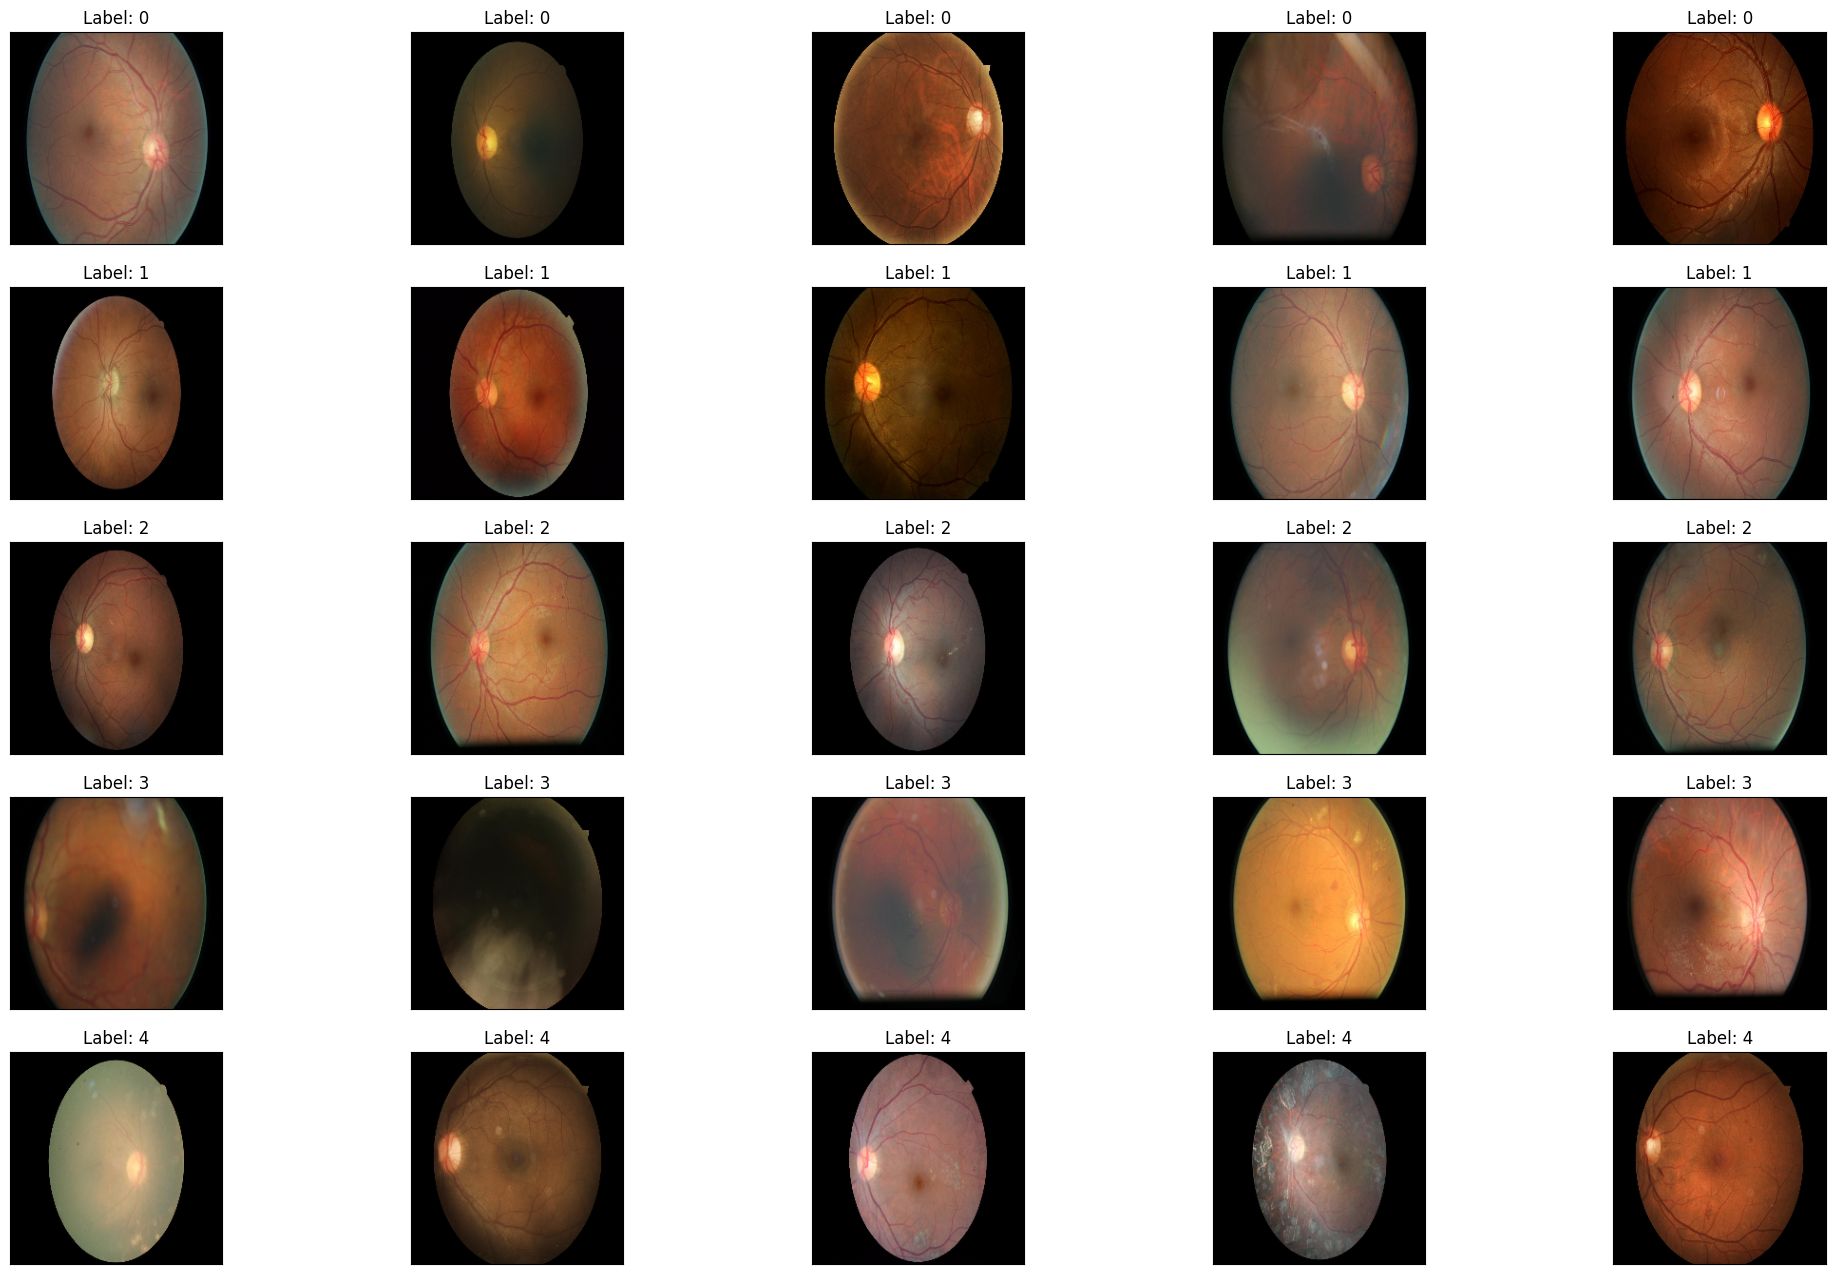

In [4]:
fig = plt.figure(figsize=(25,16))
for lev in sorted(labels.unique()):
    for i, (id, row) in enumerate(data[data['level'] == lev].sample(5, random_state = 0).iterrows()):
        ax = fig.add_subplot(5, 5, lev * 5 + i + 1, xticks=[], yticks=[])
        path = f'{FILE_PATH}/{row["image"]}.jpeg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title(f"Label: {row['level']}")

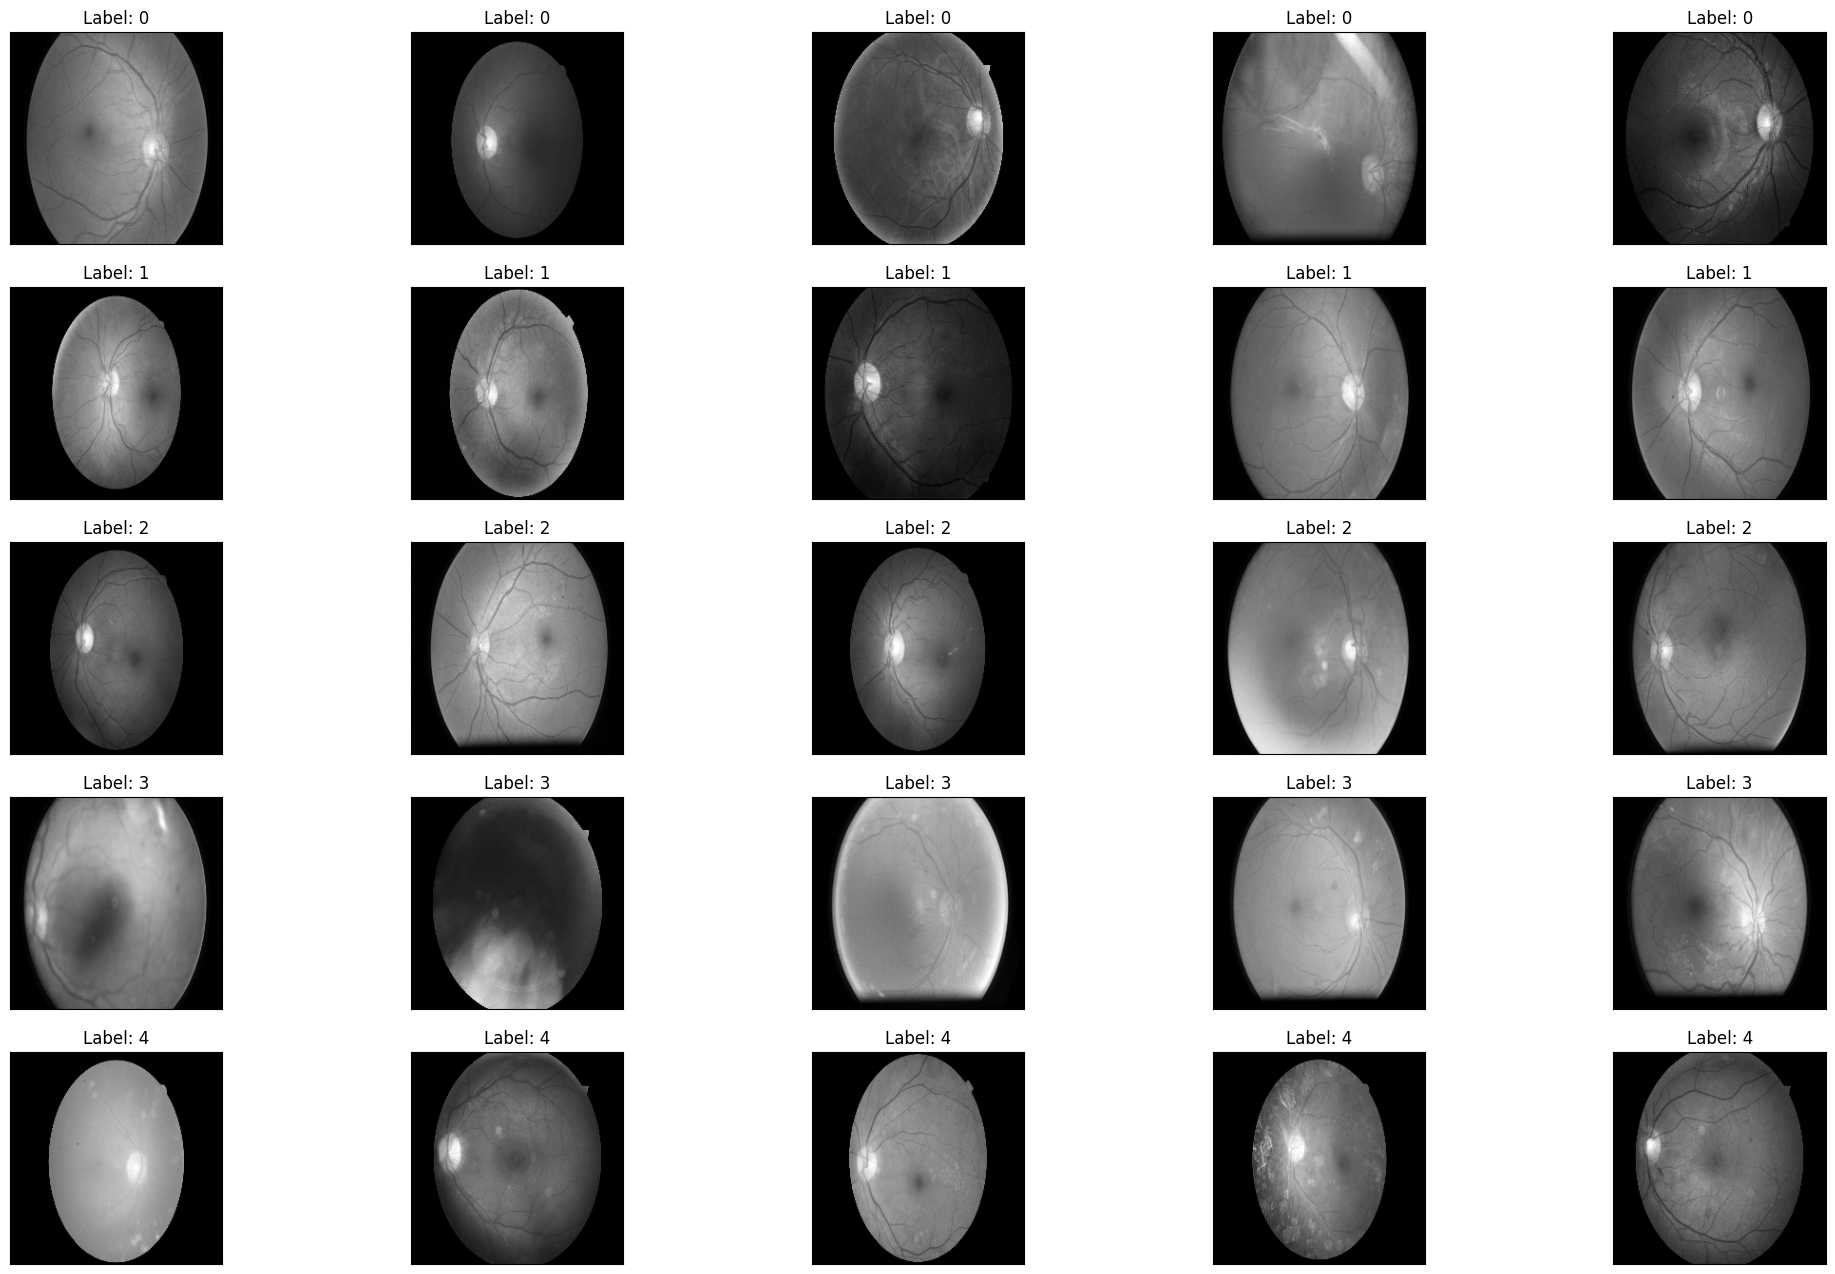

In [5]:
fig = plt.figure(figsize=(25,16))
for lev in sorted(labels.unique()):
    for i, (id, row) in enumerate(data[data['level'] == lev].sample(5, random_state = 0).iterrows()):
        ax = fig.add_subplot(5, 5, lev * 5 + i + 1, xticks=[], yticks=[])
        path = f'{FILE_PATH}/{row["image"]}.jpeg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image, cmap='gray')
        ax.set_title(f"Label: {row['level']}")

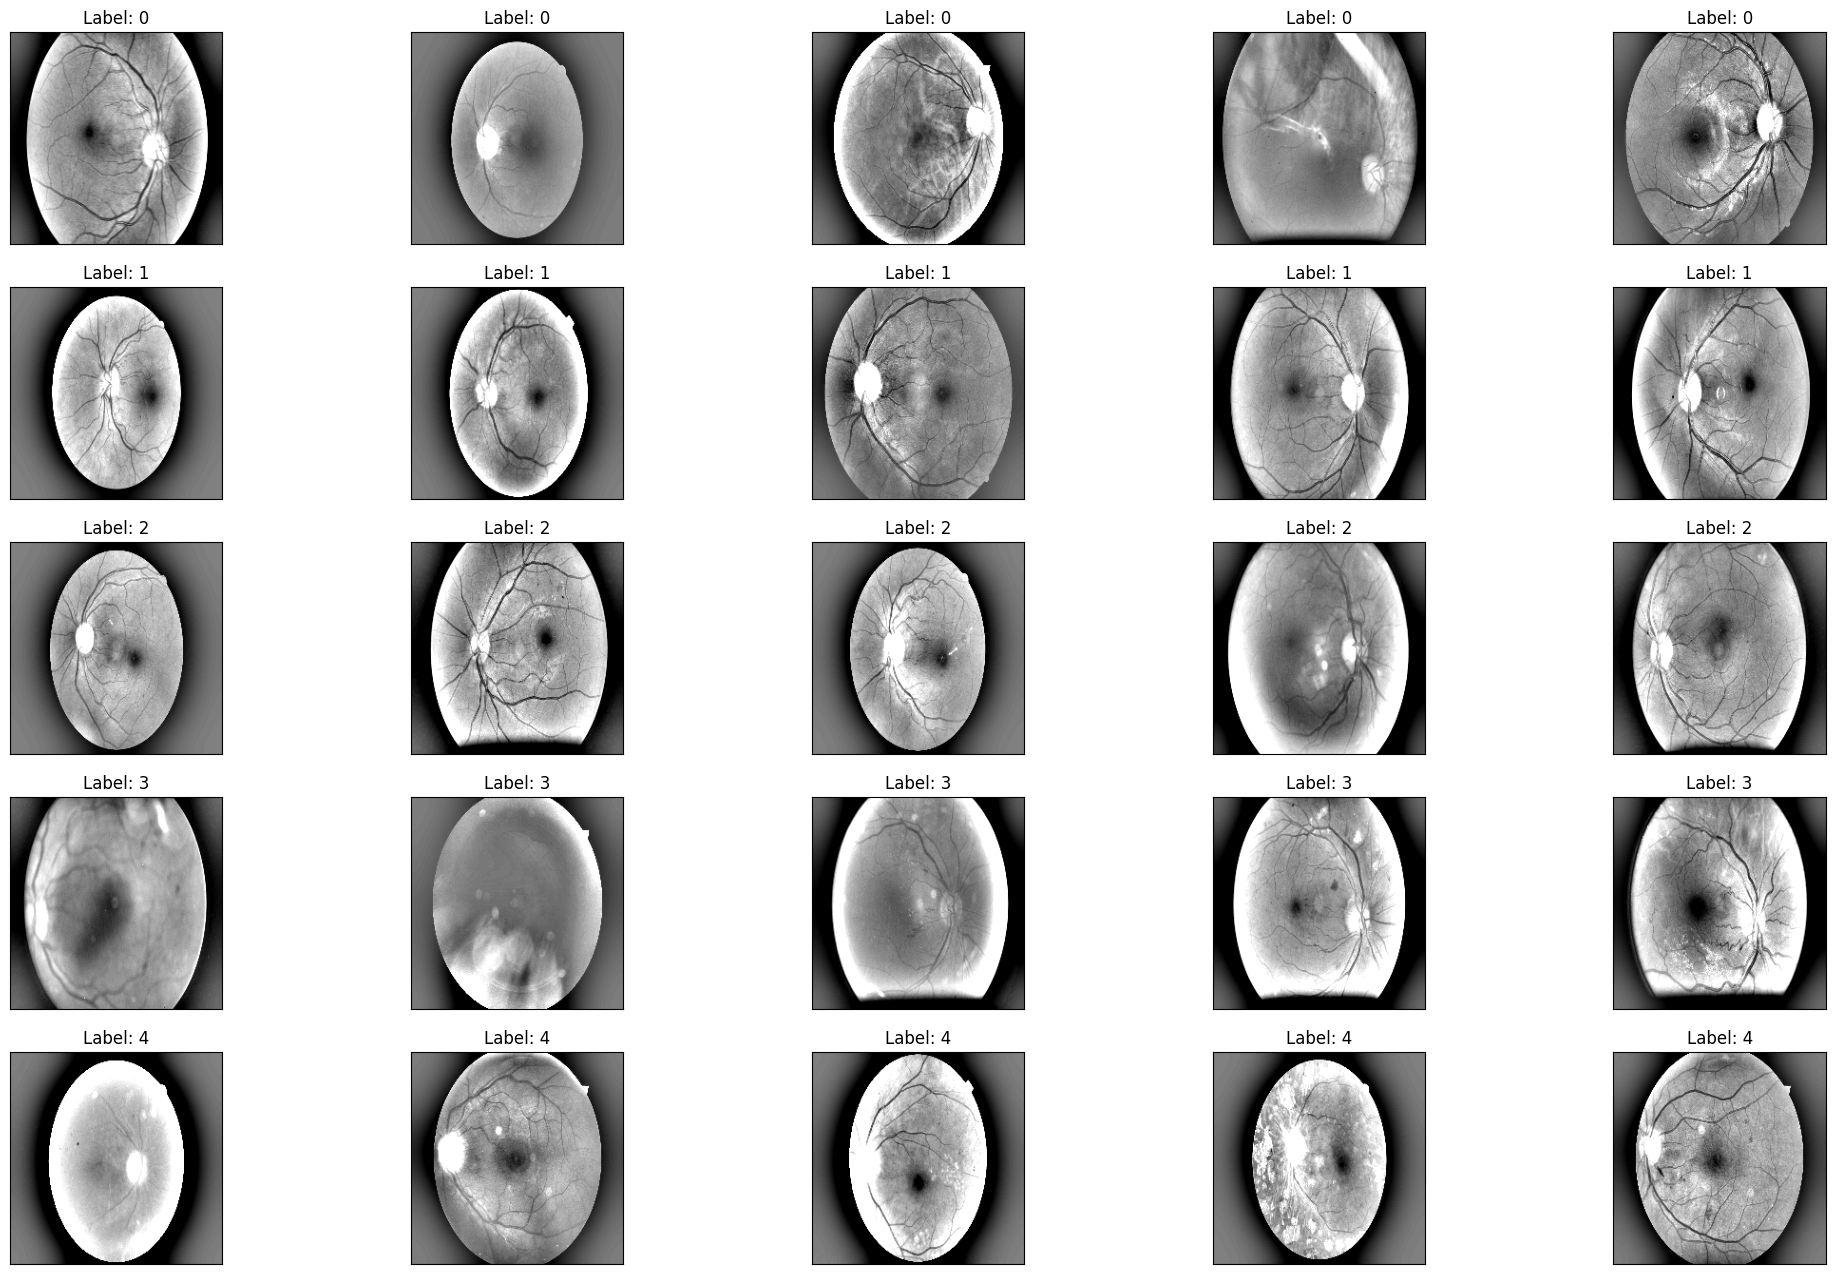

In [6]:
fig = plt.figure(figsize=(25,16))
for lev in sorted(labels.unique()):
    for i, (id, row) in enumerate(data[data['level'] == lev].sample(5, random_state = 0).iterrows()):
        ax = fig.add_subplot(5, 5, lev * 5 + i + 1, xticks=[], yticks=[])
        path = f'{FILE_PATH}/{row["image"]}.jpeg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)

        plt.imshow(image, cmap='gray')
        ax.set_title(f"Label: {row['level']}")

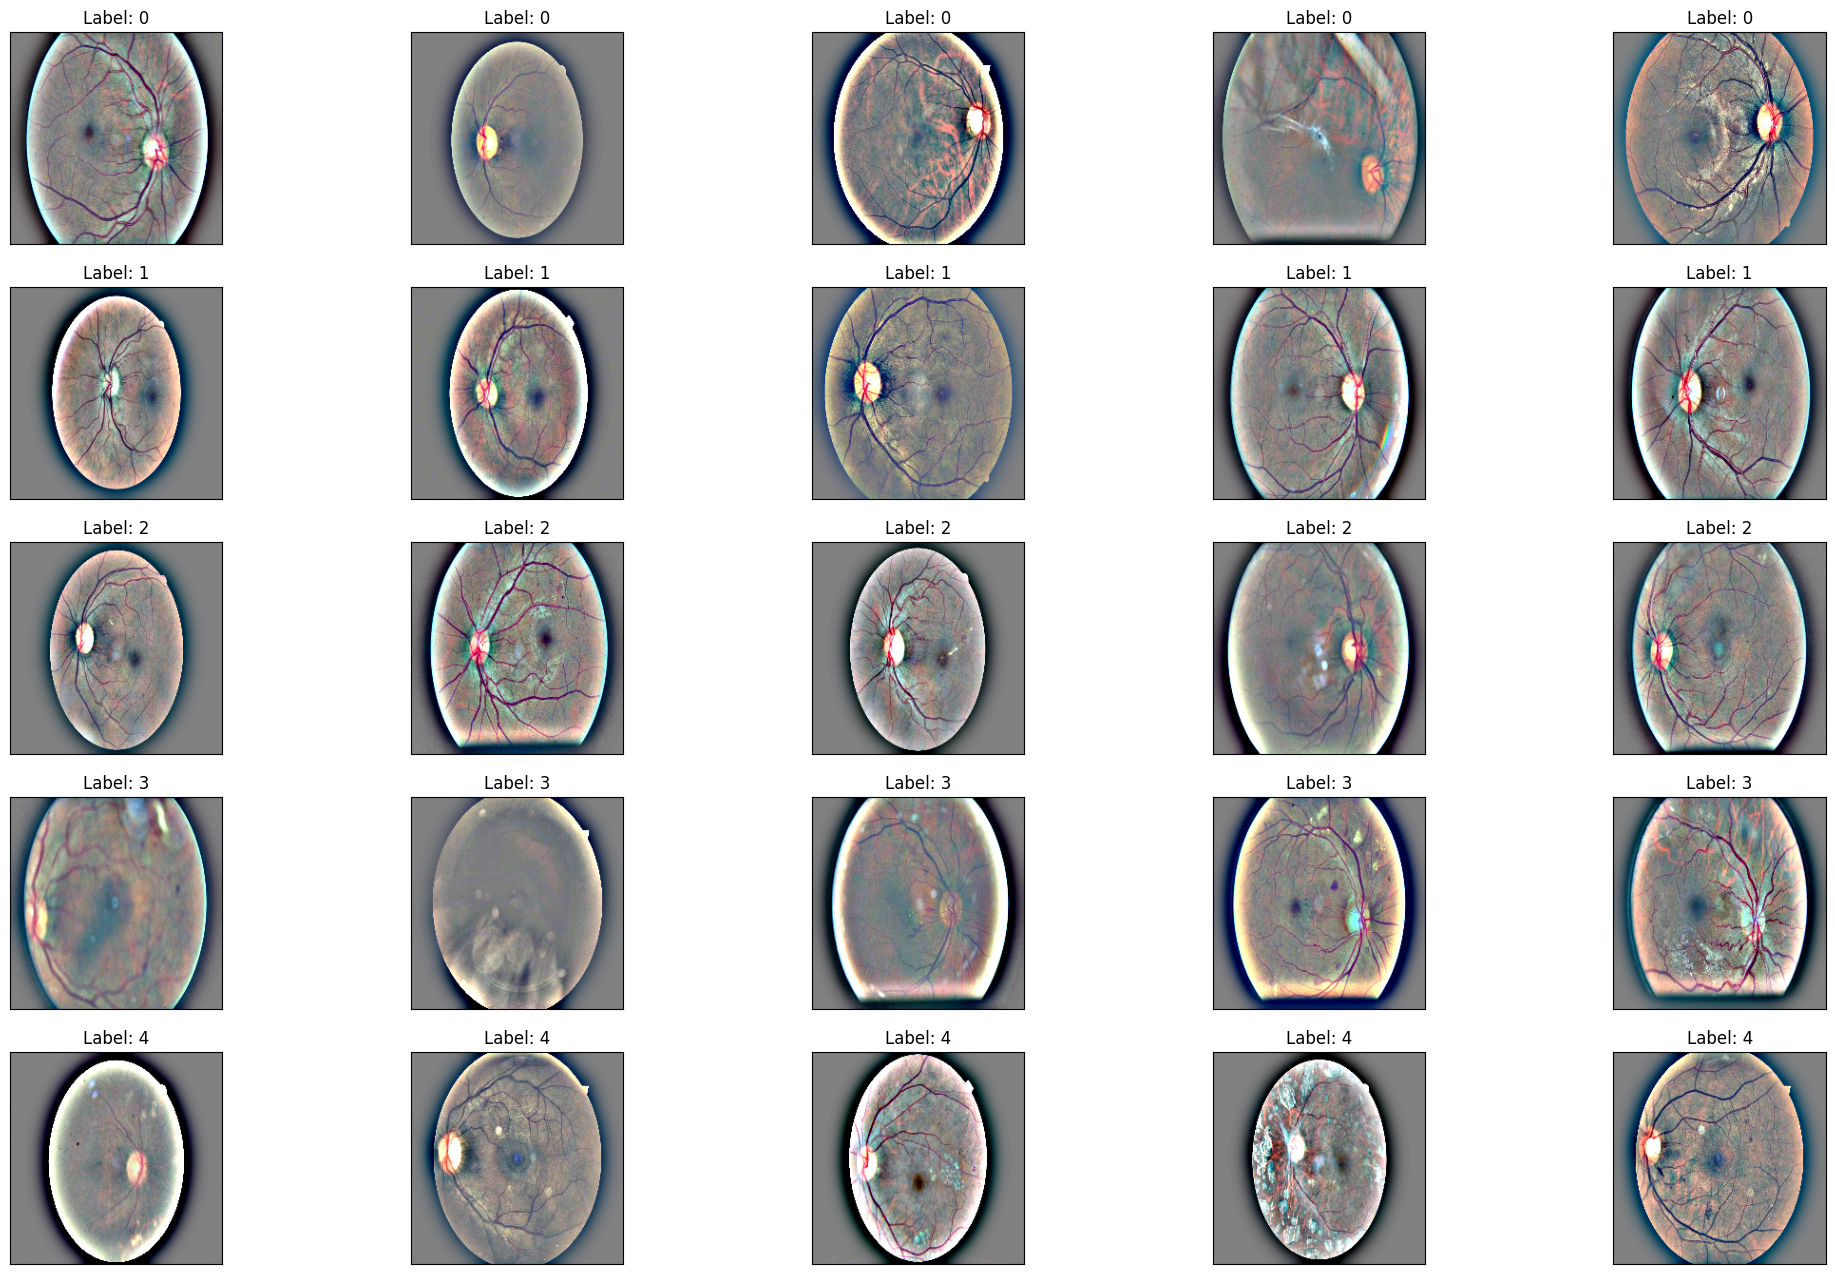

In [7]:
fig = plt.figure(figsize=(25,16))
for lev in sorted(labels.unique()):
    for i, (id, row) in enumerate(data[data['level'] == lev].sample(5, random_state = 0).iterrows()):
        ax = fig.add_subplot(5, 5, lev * 5 + i + 1, xticks=[], yticks=[])
        path = f'{FILE_PATH}/{row["image"]}.jpeg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

        plt.imshow(image)
        ax.set_title(f"Label: {row['level']}")

In [8]:
def preprocess_image(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)
  image =  image/255.0
  return image

train_datagen = ImageDataGenerator(
  rotation_range = 0.15,
  shear_range = 10,
  zoom_range = 0.2,
  horizontal_flip = True,
  preprocessing_function = preprocess_image,
  validation_split = 0.25
)

test_datagen = ImageDataGenerator(
  preprocessing_function = preprocess_image
)

images_name = images_name.apply(lambda x: f"{x}.jpeg" )
labels = labels.replace({
0: "No retinopathy",
1: "Mild non-proliferative diabetic retinopathy (NPDR)",
2: "Moderate NPDR",
3: "Severe NPDR",
4: "Proliferative diabetic retinopathy (PDR)"
})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_name, labels, test_size=0.25, random_state = 42)

train = pd.DataFrame({'image':x_train, 'labels':y_train})
test = pd.DataFrame({'image':x_test, 'labels':y_test})

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
  dataframe=train,
  directory = FILE_PATH,
  x_col='image',
  y_col="labels",
  target_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset='training',
  class_mode = 'categorical',
  shuffle=True
)
val_generator = train_datagen.flow_from_dataframe(
  dataframe=train,
  directory = FILE_PATH,
  x_col='image',
  y_col="labels",
  target_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  subset='validation',
  class_mode = 'categorical',
  shuffle="True"
)
test_generator = test_datagen.flow_from_dataframe(
  dataframe=test,
  directory = FILE_PATH,
  x_col='image',
  y_col="labels",
  target_size = (IMG_SIZE, IMG_SIZE),
  batch_size = BATCH_SIZE,
  class_mode = 'categorical'
)

Found 19758 validated image filenames belonging to 5 classes.
Found 6586 validated image filenames belonging to 5 classes.
Found 8782 validated image filenames belonging to 5 classes.


In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("./DR_model.keras", monitor='val_accuracy', verbose=1, save_best_only = True, mode='max')
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_generator, steps_per_epoch = train_generator.samples//train_generator.batch_size, validation_data = val_generator,
                    validation_steps = val_generator.samples//val_generator.batch_size, epochs = 80,
                    callbacks=checkpoint, verbose=1)

In [10]:
from keras.saving import load_model

model = load_model('DR_model_retrained.keras')
loss, accuracy = model.evaluate(test_generator)
print(accuracy)

275/275 ━━━━━━━━━━━━━━━━━━━━ 229s 826ms/step - accuracy: 0.7404 - loss: 0.8424
0.7396948337554932
